In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import model
import csv
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

if not torch.cuda.is_available():
    from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

shape = (44, 44)

In [8]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self, transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)

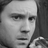

training size 28709 : private val size 3589 : public val size 3589


In [19]:
from IPython.display import display
class DataSetFactory():

    def __init__(self):
        images = []
        emotions = []
        private_images = []
        private_emotions = []
        public_images = []
        public_emotions = []

        cnt=0
        with open('../dataset/fer2013.csv', 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')
                if(cnt==0):
                    img=Image.fromarray(face)
                    display(img)
                    cnt+=1

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                elif row[-1] == "PrivateTest":
                    private_emotions.append(int(row[0]))
                    private_images.append(Image.fromarray(face))
                elif row[-1] == "PublicTest":
                    public_emotions.append(int(row[0]))
                    public_images.append(Image.fromarray(face))

        print('training size %d : private val size %d : public val size %d' % (
            len(images), len(private_images), len(public_images)))
        train_transform = transforms.Compose([
            transforms.RandomCrop(shape[0]),
            transforms.RandomHorizontalFlip(),
            ToTensor(),
        ])
        val_transform = transforms.Compose([
            transforms.CenterCrop(shape[0]),
            ToTensor(),
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.private = DataSet(transform=val_transform, images=private_images, emotions=private_emotions)
        self.public = DataSet(transform=val_transform, images=public_images, emotions=public_emotions)

datas=DataSetFactory()

In [ ]:
def main():
    # variables  -------------
    batch_size = 128
    lr = 0.01
    epochs = 300
    learning_rate_decay_start = 80
    learning_rate_decay_every = 5
    learning_rate_decay_rate = 0.9
    # ------------------------

    classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    network = model.Model(num_classes=len(classes)).to(device)
    if not torch.cuda.is_available():
        summary(network, (1, shape[0], shape[1]))

    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9, weight_decay=5e-3)
    criterion = nn.CrossEntropyLoss()
    factory = DataSetFactory()

    training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=1)
    validation_loader = {
        'private': DataLoader(factory.private, batch_size=batch_size, shuffle=True, num_workers=1),
        'public': DataLoader(factory.public, batch_size=batch_size, shuffle=True, num_workers=1)
    }

    min_validation_loss = {
        'private': 10000,
        'public': 10000,
    }

    for epoch in range(epochs):
        network.train()
        total = 0
        correct = 0
        total_train_loss = 0
        if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:

            #
            frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
            decay_factor = learning_rate_decay_rate ** frac
            current_lr = lr * decay_factor
            for group in optimizer.param_groups:
                group['lr'] = current_lr
        else:
            current_lr = lr

        print('learning_rate: %s' % str(current_lr))
        for i, (x_train, y_train) in enumerate(training_loader):
            optimizer.zero_grad()
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_predicted = network(x_train)
            loss = criterion(y_predicted, y_train)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(y_predicted.data, 1)
            total_train_loss += loss.data
            total += y_train.size(0)
            correct += predicted.eq(y_train.data).sum()
        accuracy = 100. * float(correct) / total
        print('Epoch [%d/%d] Training Loss: %.4f, Accuracy: %.4f' % (
            epoch + 1, epochs, total_train_loss / (i + 1), accuracy))

        network.eval()
        with torch.no_grad():
            for name in ['private', 'public']:
                total = 0
                correct = 0
                total_validation_loss = 0
                for j, (x_val, y_val) in enumerate(validation_loader[name]):
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    y_val_predicted = network(x_val)
                    val_loss = criterion(y_val_predicted, y_val)
                    _, predicted = torch.max(y_val_predicted.data, 1)
                    total_validation_loss += val_loss.data
                    total += y_val.size(0)
                    correct += predicted.eq(y_val.data).sum()

                accuracy = 100. * float(correct) / total
                if total_validation_loss <= min_validation_loss[name]:
                    if epoch >= 10:
                        print('saving new model')
                        state = {'net': network.state_dict()}
                        torch.save(state, '../trained/%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
                    min_validation_loss[name] = total_validation_loss

                print('Epoch [%d/%d] %s validation Loss: %.4f, Accuracy: %.4f' % (
                    epoch + 1, epochs, name, total_validation_loss / (j + 1), accuracy))